Using Carolyn's dataset that adds **area** and **population density**.

This notebook is focused on trying Dr. Dimakis' suggestion of trying different subsets to see how COVID stats interacts with other features.

In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns 

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

## File Upload and Data Read

In [117]:
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['county_statistics_v2.csv']))

Saving county_statistics_v2.csv to county_statistics_v2 (3).csv


## Data Preprocessing

In [118]:
## Prepare data by getting rid of missing values and features we don't want to use.

# Drop 2016 results, too powerful to use.
data = data.drop(['percentage16_Donald_Trump', 'percentage16_Hillary_Clinton', 'total_votes16', 'votes16_Donald_Trump', 'votes16_Hillary_Clinton'],  axis=1)

# Drop county name
data = data.drop('county', axis=1)

# Drop state
data = data.drop('state', axis=1)

# Drop rows with any NaN in the label column. Now have about ~3k useable counties left.
data = data.dropna(how='any', subset=['percentage20_Donald_Trump'])

# Drop rows with any NaN in the lat, long, cases, deaths columns. There are about 40 of these.
data = data.dropna(how='any', subset=['lat'])

In [119]:
data.corr()

,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden,lat,long,cases,deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,area,population_density
percentage20_Donald_Trump,1.000000,-0.998733,-0.370332,-0.326454,-0.378744,-0.051793,-0.066324,-0.314630,-0.302995,-0.367887,-0.366388,-0.369252,-0.145908,0.513229,-0.420482,-0.105082,-0.458037,-0.096154,-0.385844,-0.225678,0.341085,-0.274535,0.308337,-0.120597,-0.095705,-0.320422,-0.264579,-0.190280,0.489846,0.275038,0.145737,0.093496,-0.356465,-0.018857,-0.175306,0.023621,-0.095668,-0.373715,-0.118968,-0.072148,0.318070,0.151029,-0.247049,-0.030389,-0.142094
percentage20_Joe_Biden,-0.998733,1.000000,0.372082,0.327759,0.380814,0.029715,0.085236,0.317349,0.308228,0.369809,0.368205,0.371274,0.150541,-0.526571,0.437813,0.099995,0.456553,0.092752,0.387781,0.214715,-0.340824,0.265087,-0.307953,0.132830,0.110487,0.309763,0.267449,0.192687,-0.487840,-0.267689,-0.137851,-0.092490,0.358919,0.007833,0.173703,-0.033120,0.108017,0.375396,0.122966,0.070225,-0.322267,-0.154769,0.258463,0.020133,0.144537
total_votes20,-0.370332,0.372082,1.000000,0.949805,0.984234,-0.059706,-0.024071,0.915911,0.729894,0.975455,0.975827,0.974878,0.168035,-0.228414,0.068757,-0.047758,0.501759,0.065040,0.979672,0.284530,-0.251283,0.289843,-0.252437,-0.091251,-0.081510,0.287767,-0.016120,0.203673,-0.293613,-0.207707,-0.108281,-0.077711,0.349963,-0.063488,0.071677,0.000431,0.158600,0.976736,0.215784,-0.158997,-0.156251,-0.085412,0.018245,0.101899,0.187647
votes20_Donald_Trump,-0.326454,0.327759,0.949805,1.000000,0.879561,-0.091591,0.006885,0.868181,0.659357,0.909065,0.910164,0.907800,0.159047,-0.193996,0.044809,-0.058639,0.448815,0.056691,0.918880,0.304505,-0.294791,0.289759,-0.298062,-0.120865,-0.103911,0.280757,-0.027961,0.274306,-0.318317,-0.211740,-0.022029,-0.090132,0.254379,-0.118146,0.040402,-0.019890,0.163796,0.905746,0.272518,-0.200378,-0.198516,-0.102853,0.009980,0.118057,0.138531
votes20_Joe_Biden,-0.378744,0.380814,0.984234,0.879561,1.000000,-0.040364,-0.038119,0.903673,0.740247,0.970166,0.970042,0.970069,0.165919,-0.238611,0.080390,-0.039561,0.509195,0.065955,0.971051,0.259919,-0.215417,0.276828,-0.215268,-0.069842,-0.064415,0.278495,-0.008218,0.154666,-0.266489,-0.196073,-0.152966,-0.067507,0.390644,-0.029721,0.086048,0.011637,0.149564,0.973927,0.174264,-0.128737,-0.125383,-0.071743,0.022723,0.087455,0.208659
lat,-0.051793,0.029715,-0.059706,-0.091591,-0.040364,1.000000,-0.177387,-0.094996,-0.044770,-0.057260,-0.057077,-0.057424,-0.324496,0.523811,-0.462020,0.139643,-0.027739,-0.098136,-0.053400,0.267604,-0.036954,0.329158,0.011228,-0.387430,-0.404566,0.257638,-0.132113,-0.181611,-0.073002,-0.055688,-0.299268,-0.147156,0.073356,0.388730,-0.042594,0.369461,-0.271350,-0.045501,-0.034866,-0.124403,0.236825,0.164106,-0.346253,0.103618,0.007459
long,-0.066324,0.085236,-0.024071,0.006885,-0.038119,-0.177387,1.000000,0.000748,0.083796,-0.012582,-0.016149,-0.009138,-0.342344,0.113206,0.298528,-0.163867,-0.128076,-0.296722,0.000474,-0.047042,-0.226457,-0.031437,-0.225885,0.081352,0.137785,-0.069160,-0.054100,0.174323,-0.300031,0.233637,0.342627,-0.139407,0.046986,-0.297505,-0.142721,-0.322611,0.363503,-0.009168,0.343220,-0.187454,-0.341896,-0.189171,0.149625,-0.486308,0.062532
cases,-0.314630,0.317349,0.915911,0.868181,0.903673,-0.094996,0.000748,1.000000,0.821047,0.950320,0.949436,0.950961,0.219125,-0.263716,0.090521,-0.033600,0.379913,0.029504,0.938211,0.181702,-0.211326,0.182437,-0.213036,-0.024575,-0.019451,0.185873,0.019127,0.177774,-0.222460,-0.153707,-0.119503,-0.049644,0.366228,-0.050718,0.060913,-0.024918,0.136020,0.944024,0.175685,-0.128178,-0.128994,-0.071553,0.039704,0.113934,0.

In [ ]:
# Split label
trump = data['percentage20_Donald_Trump']

# Remove all other 2020 voting info
data = data.drop(['percentage20_Donald_Trump', 'percentage20_Joe_Biden', 'votes20_Donald_Trump', 'votes20_Joe_Biden'],  axis=1)

In [ ]:
# Create new features to capture COVID data per capita
data["cases_per_pop"] = data['cases'] / data['TotalPop'] 
data['death_per_pop'] = data['deaths'] / data['TotalPop']

In [ ]:
# Drop old population related stats and flat covid
data = data.drop(['TotalPop', 'total_votes20', 'cases', 'deaths'], axis=1)

In [ ]:
data.head()

,lat,long,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,area,population_density,cases_per_pop,death_per_pop
0,32.539527,-86.644082,26899.0,28137.0,2.7,75.4,18.9,0.3,0.9,0.0,41016.0,55317.0,2838.0,27824.0,2024.0,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112.0,74.1,20.2,5.6,0.1,5.2,594.44,92.584617,0.039483,0.000563
1,30.727750,-87.722071,99527.0,103833.0,4.4,83.1,9.5,0.8,0.7,0.0,155376.0,52562.0,1348.0,29364.0,735.0,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527.0,80.7,12.9,6.3,0.1,5.5,1589.78,127.917070,0.034255,0.000349
2,31.868263,-85.387129,13976.0,12225.0,4.2,45.7,47.8,0.2,0.6,0.0,20269.0,33368.0,2551.0,17561.0,798.0,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878.0,74.1,19.1,6.5,0.3,12.4,884.88,29.609665,0.040495,0.000343
3,32.996421,-87.125115,12251.0,10329.0,2.4,74.6,22.0,0.4,0.0,0.0,17662.0,43404.0,3431.0,20911.0,1889.0,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171.0,76.0,17.4,6.3,0.3,8.2,622.58,36.268431,0.038884,0.000664
4,33.982109,-86.567906,28490.0,29177.0,9.0,87.4,1.5,0.3,0.1,0.0,42513.0,47412.0,2630.0,22021.0,850.0,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380.0,83.9,11.9,4.0,0.1,4.9,644.78,89.436707,0.036329,0.000434


In [115]:
data.corr()

,lat,long,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,area,population_density,cases_per_pop,death_per_pop
lat,1.000000,-0.177387,-0.057077,-0.057424,-0.324496,0.523811,-0.462020,0.139643,-0.027739,-0.098136,-0.053400,0.267604,-0.036954,0.329158,0.011228,-0.387430,-0.404566,0.257638,-0.132113,-0.181611,-0.073002,-0.055688,-0.299268,-0.147156,0.073356,0.388730,-0.042594,0.369461,-0.271350,-0.045501,-0.034866,-0.124403,0.236825,0.164106,-0.346253,0.103618,0.007459,-0.173524,-0.324149
long,-0.177387,1.000000,-0.016149,-0.009138,-0.342344,0.113206,0.298528,-0.163867,-0.128076,-0.296722,0.000474,-0.047042,-0.226457,-0.031437,-0.225885,0.081352,0.137785,-0.069160,-0.054100,0.174323,-0.300031,0.233637,0.342627,-0.139407,0.046986,-0.297505,-0.142721,-0.322611,0.363503,-0.009168,0.343220,-0.187454,-0.341896,-0.189171,0.149625,-0.486308,0.062532,-0.015503,0.140919
Men,-0.057077,-0.016149,1.000000,0.999545,0.194901,-0.246927,0.067749,-0.044318,0.500522,0.065698,0.996296,0.259137,-0.240137,0.261418,-0.242401,-0.067529,-0.060091,0.256158,0.003121,0.184119,-0.269116,-0.191879,-0.140005,-0.067863,0.406534,-0.045492,0.071904,-0.011292,0.161568,0.997858,0.195688,-0.142894,-0.143332,-0.080839,0.032239,0.113698,0.205220,-0.004698,0.067873
Women,-0.057424,-0.009138,0.999545,1.000000,0.192372,-0.248099,0.072615,-0.044544,0.498039,0.062467,0.997036,0.257173,-0.240849,0.262678,-0.242719,-0.065920,-0.058047,0.258072,0.002801,0.185755,-0.272229,-0.192445,-0.143686,-0.070584,0.417843,-0.044723,0.070809,-0.011949,0.163361,0.997851,0.197618,-0.144934,-0.143842,-0.081108,0.033595,0.108172,0.210522,-0.004606,0.072276
Hispanic,-0.324496,-0.342344,0.194901,0.192372,1.000000,-0.622767,-0.116108,-0.031648,0.147090,0.042032,0.180708,0.043433,0.102796,-0.060835,0.046775,0.079892,0.075268,-0.088776,0.153416,-0.031947,0.252021,-0.161297,-0.145597,0.238345,0.116572,-0.029281,0.090960,-0.031299,-0.106154,0.184993,-0.076513,0.099247,-0.003415,-0.027274,0.059067,0.261563,0.045413,0.113925,0.143473
White,0.523811,0.113206,-0.246927,-0.248099,-0.622767,1.000000,-0.608681,-0.238720,-0.266531,-0.115290,-0.242706,0.133549,0.029667,0.222869,0.076364,-0.462889,-0.452736,0.085276,-0.274319,-0.059903,-0.009597,0.117211,0.035453,-0.173552,-0.188688,0.140767,-0.112421,0.180814,-0.054403,-0.239684,0.141492,-0.327139,0.220745,0.089952,-0.439842,-0.145013,-0.084441,-0.327280,-0.430503
Black,-0.462020,0.298528,0.067749,0.072615,-0.116108,-0.608681,1.000000,-0.095282,0.020465,-0.045187,0.074891,-0.277296,-0.084666,-0.268711,-0.084966,0.475275,0.499469,-0.144164,0.155734,0.116965,-0.167284,0.119423,0.203888,0.006921,0.056841,-0.226684,0.034045,-0.302171,0.214605,0.065643,0.037102,0.160286,-0.300160,-0.125277,0.448984,-0.159877,0.028810,0.284823,0.438335
Native,0.139643,-0.163867,-0.044318,-0.044544,-0.031648,-0.238720,-0.095282,1.000000,-0.052196,0.024889,-0.047804,-0.103745,0.004107,-0.149122,-0.011032,0.262241,0.202273,0.051442,0.149750,-0.084477,0.029966,-0.128822,-0.136946,0.015614,-0.016499,0.130342,0.005602,0.172755,-0.136372,-0.046107,-0.398270,0.435576,0.077773,0.102318,0.229789,0.221911,-0.015908,0.174836,0.071590
Asian,-0.027739,-0.128076,0.500522,0.498039,0.147090,-0.266531,0.020465,-0.052196,1.000000,0.436360,0.508093,0.454442,-0.222788,0.419181,-0.235751,-0.144927,-0.170783,0.411053,-0.020431,0.117235,-0.337570,-0.265324,-0.235147,-0.050087,0.483226,0.018541,0.136134,0.020399,0.124197,0.514468,0.143575,-0.065935,-0.160918,-0.091110,-0.027265,0.012949,0.259051,-0.045900,0.009801
Pacific,-0.098136,-0.296722,0.065698,0.062467,0.042032,-0.115290,-0.045187,0.024889,0.436360,1.000000,0.066431,0.073063,-0.031250,0.028858,-0.045486,-0.027916,-0.044099,0.016683,0.084973,0.040296,-0.020141,-0.079201,-0.072648,0.0

## Subset Creation
Here we are selecting a subset of features that the model will use.

In [ ]:
subset_data = data[["population_density", 'cases_per_pop', 'death_per_pop' ]].copy()
# subset_data = data.drop(['cases_per_pop'], axis=1) "cases_per_pop", "death_per_pop"

# subset_data = no_flat.drop(['White','Black','Asian','Transit', 'cases_per_pop', 'death_per_pop'], axis=1)
# no_flat = data.drop(['VotingAgeCitizen', "Employed"], axis=1)

## Model Creation

Using an untuned Gradient Boosting here. Not interested in predicting Trump percentage as accurately as possible here but rather how COVID stats interact with other features. Chose Gradient Boosting because it was the best out-of-the-box model when doing inital testing (see Matt.ipynb)

**Questions:**

1. Are there features that render the COVID stats useless?
2. Are there subsets of features for which the COVID stats help? Help a lot? What are they and what are the possible explanations?

In [ ]:
gb = GradientBoostingRegressor(random_state=0)

In [ ]:
scores = cross_val_score(gb, subset_data, trump, cv=10, scoring="neg_mean_absolute_error")
print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

Accuracy: -0.10293 (+/- 0.01915)


# Results

All results below are using (negative) MAE unless otherwise stated.

MAE can be interpreted as "on average, the prediction is {MAE VALUE} distance away from the real result".

---
## Baseline Tests
Using all features : Accuracy: **-0.05250** (+/- 0.01041)

Using all features BUT COVID cols: Accuracy: **-0.05277** (+/- 0.00973) --> Just barley worse!!

Using all features BUT DEATH col: Accuracy: **-0.05266** (+/- 0.01059) --> A litte better than no COVID columns at all. Adding in the cases helped a VERY small amount.

Using all features BUT CASES col: Accuracy: **-0.05244** (+/- 0.01006) --> This is actually a slight performance increase when compared to using all features. Adding in cases seems to bring the score down? Maybe overfitting?

Using JUST covid_per_capita, deaths_per_capita: Accuracy: **-0.12511** (+/- 0.02012) --> Only using 2 features here so wouldn't expect very good results but still able to predict somewhat.

---
### Adding by Rank
> Rank: 1, Feature: Employed 
Rank: 2, Feature: White
Rank: 3, Feature: Transit
Rank: 4, Feature: Asian
Rank: 5, Feature: Black
Rank: 6, Feature: Construction
Rank: 7, Feature: lat
Rank: 8, Feature: long
Rank: 9, Feature: Production
Rank: 10, Feature: Drive

1. Just Employed: Accuracy: -0.10065 (+/- 0.01673) 

 - Employed + COVID: Accuracy: -0.09919 (+/- 0.01827) --> COVID stats miminally increase performance, trend continues...

2. Employed, White: Accuracy: -0.08806 (+/- 0.02827)

 - Employed, White + COVID: Accuracy: -0.08699 (+/- 0.03040)

3. Employed, White, Transit: Accuracy: -0.08161 (+/- 0.02450)

 - Employed, White, Transit, COVID: Accuracy: -0.08106 (+/- 0.02764)

4. ..., Asian: Accuracy: -0.08013 (+/- 0.02387)

 - ..., Asian + COVID: Accuracy: -0.07925 (+/- 0.02624)

5. ..., Black: Accuracy: -0.07173 (+/- 0.01685)

 - ..., Black + COVID: Accuracy: -0.07099 (+/- 0.01776)

6. ..., Construction: Accuracy: -0.06819 (+/- 0.01488)

 - ..., Construction + COVID: -0.06759 (+/- 0.01668)

7. ..., lat: Accuracy: -0.06054 (+/- 0.01302)

 - ..., lat + COVID: Accuracy: -0.06033 (+/- 0.01451)
 
8. ..., long: Accuracy: **-0.05635** (+/- 0.01003) 

 - ..., long + COVID: Accuracy: **-0.05716** (+/- 0.01133) --> Adding COVID starts to make results WORSE here!

9. ..., Production: Accuracy: -0.05354 (+/- 0.00984)

 - ..., Production + COVID: Accuracy: -0.05426 (+/- 0.01044)

10. ..., Drive: Accuracy: -0.05323 (+/- 0.00943)

 - ..., Drive + COVID: Accuracy: -0.05388 (+/- 0.01072)
---
## Other
Just Population Density: Accuracy: -0.10417 (+/- 0.01739)

Pop. Density + COVID: Accuracy: -0.10293 (+/- 0.01915) 

---
## Summary

In most cases, adding COVID stats to other subsets of data either minimally improves the model's ability to predict or actually hurts it a small amount. After feature rank 8 is added, the performance of COVID stats being added atually makes the predictions worse. This leads me to believe we have found no evidence that the amount of COVID cases per capita has effected a county's voting one way or the other. At the very least, I am confident in saying that COVID cases and deaths were not a strong predictor of election outcome and likely did not play a strong direct role. 




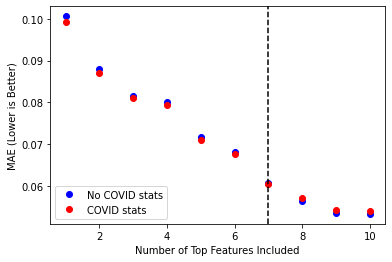

In [120]:
top10_MAE = [.10065, .08806, .08161, .08013, .07173, .06819, .06054, .05635, .05334, .05323]
top10_MAE_covid = [.09919, .08699, 0.08106, 0.07925, 0.07099,0.06759,0.06033, 0.05716, 0.05426, 0.05388]

plt.plot(range(1,11), top10_MAE, 'bo', label='No COVID stats')
plt.plot(range(1,11), top10_MAE_covid, 'ro', label='COVID stats')
plt.ylabel('MAE (Lower is Better)')
plt.xlabel('Number of Top Features Included')
plt.axvline(x=7, color='black', linestyle='dashed')
plt.legend()
plt.show()

Recall that a lower MAE means stronger predictions and is therefor better. As you can see above, adding in COVID stats minimally improves the prediction up until about feature 7 or 8 is added. Then adding in COVID stats actually worsens the predictions.

## Recursive Feature Elimination

"Recursive Feature elimination: Recursive feature elimination performs a greedy search to find the best performing feature subset. It iteratively creates models and determines the best or the worst performing feature at each iteration. It constructs the subsequent models with the left features until all the features are explored. It then ranks the features based on the order of their elimination. In the worst case, if a dataset contains N number of features RFE will do a greedy search for 2N combinations of features."

Please note that using **Gradient Boosting** effects how the features are ranked. Other rankings are likely with other models, although rankings should not be drastically different.

---


**COVID FEATURES**

Rank of death_per_pop: 33

Rank of cases_per_pop: 21




**FEATURE RANKS**

Rank: 1, Feature: Employed

Rank: 2, Feature: White

Rank: 3, Feature: Transit

Rank: 4, Feature: Asian

Rank: 5, Feature: Black

Rank: 6, Feature: Construction

Rank: 7, Feature: lat

Rank: 8, Feature: long

Rank: 9, Feature: Production

Rank: 10, Feature: Drive

Rank: 11, Feature: VotingAgeCitizen

Rank: 12, Feature: IncomePerCap

Rank: 13, Feature: Service

Rank: 14, Feature: population_density

Rank: 15, Feature: Unemployment

Rank: 16, Feature: WorkAtHome

Rank: 17, Feature: Women

Rank: 18, Feature: Income

Rank: 19, Feature: Walk

Rank: 20, Feature: Office

Rank: 21, Feature: cases_per_pop

Rank: 22, Feature: Professional

Rank: 23, Feature: area

Rank: 24, Feature: Poverty

Rank: 25, Feature: OtherTransp

Rank: 26, Feature: SelfEmployed

Rank: 27, Feature: PublicWork

Rank: 28, Feature: Hispanic

Rank: 29, Feature: IncomeErr

Rank: 30, Feature: ChildPoverty

Rank: 31, Feature: MeanCommute

Rank: 32, Feature: Men

Rank: 33, Feature: death_per_pop

Rank: 34, Feature: Native

Rank: 35, Feature: IncomePerCapErr

Rank: 36, Feature: Carpool

Rank: 37, Feature: PrivateWork

Rank: 38, Feature: FamilyWork

Rank: 39, Feature: Pacific


Code for RFE generation

In [ ]:
from sklearn.feature_selection import RFE

selector = RFE(gb, n_features_to_select=1, step=1)
selector.fit(data, trump)

RFE(estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                        criterion='friedman_mse', init=None,
                                        learning_rate=0.1, loss='ls',
                                        max_depth=3, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_iter_no_change=None,
                                        presort='deprecated', random_state=0,
                                        subsample=1.0, tol=0.0001,
                                        validation_fraction=0.1, verbose=0,
                                        warm_start=False),
    n_feat

In [ ]:
# Print rank of death and cases per pop
print("COVID FEATURES")
print(f'Rank of death_per_pop: {list(selector.ranking_)[list(data.columns).index("death_per_pop")]}')
print(f'Rank of cases_per_pop: {list(selector.ranking_)[list(data.columns).index("cases_per_pop")]}')
print('\n')

ranks = {}

# Create ranking dict
for i, rank in enumerate(list(selector.ranking_)):
  ranks[rank] = list(data.columns)[i]

# Sort features by rank
from collections import OrderedDict 
ordered_ranks = OrderedDict(sorted(ranks.items())) 

print("FEATURE RANKS")

# Print features
for k, v in ordered_ranks.items():
    print(f'Rank: {k}, Feature: {v}')

COVID FEATURES
Rank of death_per_pop: 33
Rank of cases_per_pop: 21


FEATURE RANKS
Rank: 1, Feature: Employed
Rank: 2, Feature: White
Rank: 3, Feature: Transit
Rank: 4, Feature: Asian
Rank: 5, Feature: Black
Rank: 6, Feature: Construction
Rank: 7, Feature: lat
Rank: 8, Feature: long
Rank: 9, Feature: Production
Rank: 10, Feature: Drive
Rank: 11, Feature: VotingAgeCitizen
Rank: 12, Feature: IncomePerCap
Rank: 13, Feature: Service
Rank: 14, Feature: population_density
Rank: 15, Feature: Unemployment
Rank: 16, Feature: WorkAtHome
Rank: 17, Feature: Women
Rank: 18, Feature: Income
Rank: 19, Feature: Walk
Rank: 20, Feature: Office
Rank: 21, Feature: cases_per_pop
Rank: 22, Feature: Professional
Rank: 23, Feature: area
Rank: 24, Feature: Poverty
Rank: 25, Feature: OtherTransp
Rank: 26, Feature: SelfEmployed
Rank: 27, Feature: PublicWork
Rank: 28, Feature: Hispanic
Rank: 29, Feature: IncomeErr
Rank: 30, Feature: ChildPoverty
Rank: 31, Feature: MeanCommute
Rank: 32, Feature: Men
Rank: 33, Feat